In [ ]:
!pip install GPyOpt
!pip install GPy

In [2]:
#import packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import GPy
import GPyOpt

In [3]:
#reading csv file for Boston Housing Dataset
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['hou_all.csv']),\
                 names = ['CRIM','ZN','INDUS','CHAS','NOS','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
df.head()

Saving hou_all.csv to hou_all.csv


,CRIM,ZN,INDUS,CHAS,NOS,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
#parameters = CRIM , ZN, INDUS
X = df.iloc[:,0:3].to_numpy()

#target = MEDV
Y = df.iloc[:,-1].to_numpy()

#train test split
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.3, random_state = 10)

rf = RandomForestRegressor()
rf.fit(xTrain,yTrain)
yPred = rf.predict(xTest)
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [5]:
bounds = [ {'name': 'max_samples', 'type': 'continuous', 'domain': (0.5, 1)},
        {'name': 'max_features', 'type': 'continuous', 'domain': (0.5, 1)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (100, 200)}
      ]

def rf_score(parameters):
  params = {
        'max_samples': parameters[0][0],
        'max_features':parameters[0][1],
        'n_estimators':int(parameters[0][2])
    }
  
  reg = RandomForestRegressor(max_samples=params['max_samples'],max_features=params['max_features'],n_estimators=params['n_estimators'])
  reg.fit(xTrain,yTrain)
  yPred = reg.predict(xTest)
    
  #using negative MSE as score (loss function)
  score = -mean_squared_error(yPred,yTest)
  return score

In [19]:
kernel = GPy.kern.Matern32(input_dim=1, variance=1.0, lengthscale=1.0) + GPy.kern.ExpQuad(input_dim=1,variance=1.0,lengthscale=1.0)

optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )

optimizer.run_optimization(max_iter=20)

#minimum MSE
MSE_min=optimizer.fx_opt
#best parameters
params_min=optimizer.x_opt
print(MSE_min)
print(params_min)

59.464266866776235
[  0.50680177   0.65899159 200.        ]


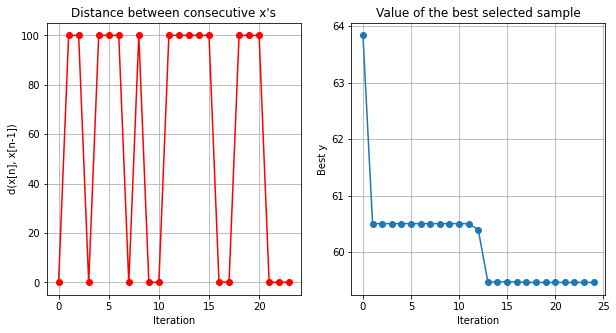

In [20]:
optimizer.plot_convergence()